In [1]:
# Cell 1: Install dependencies
!pip install yfinance pandas matplotlib seaborn scikit-learn statsmodels pmdarima keras tensorflow

In [2]:
# Cell 2: Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

c:\Users\Bob\Desktop\10Acadamy\week11\.venv\lib\site-packages\pmdarima\compat\sklearn.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
# Cell 3: Download Tesla data
start_date = "2015-07-01"
end_date = "2025-07-31"
tsla_df = yf.download("TSLA", start=start_date, end=end_date)
tsla_df = tsla_df[["Close"]]
tsla_df.dropna(inplace=True)
tsla_df.index = pd.to_datetime(tsla_df.index)
tsla_df.columns = ['TSLA_Close']
tsla_df.head()

[*********************100%***********************]  1 of 1 completed


,TSLA_Close
Date,
2015-07-01,17.943333
2015-07-02,18.667999
2015-07-06,18.648001
2015-07-07,17.858667
2015-07-08,16.997334


In [4]:
# Cell 4: Train-test split
train = tsla_df[:'2023-12-31']
test = tsla_df['2024-01-01':]

<Figure size 1200x500 with 0 Axes>

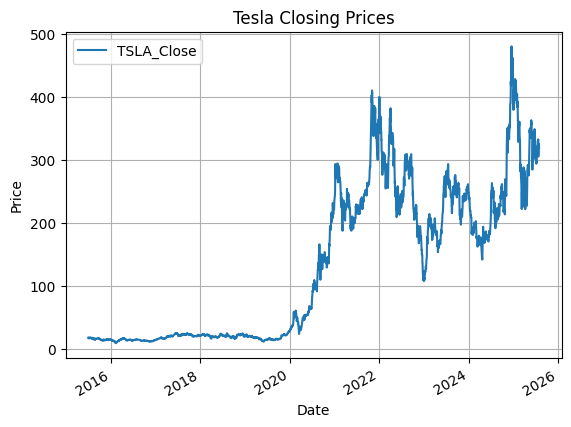

In [5]:
# Cell 5: Plot raw close prices
plt.figure(figsize=(12, 5))
tsla_df.plot(title="Tesla Closing Prices", ylabel="Price", xlabel="Date")
plt.grid()
plt.show()

In [6]:
# Cell 6: Model 1 - Auto ARIMA
model_auto = auto_arima(train, seasonal=False, trace=True)
model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13652.181, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13647.752, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13647.771, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13647.825, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13646.472, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13648.219, Time=0.82 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.221 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6822.236
Date:                Fri, 08 Aug 2025   AIC                          13646.472
Time:                        17:35:55   BIC                          13652.140
Sample:                             0   HQIC                         13648.546
                               - 2140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        34.5030      0.413     83.548      0.000      33.694      35.312
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):             10936.43
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):             442.45   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [7]:
# Cell 7: Fit ARIMA model
model = ARIMA(train, order=model_auto.order)
fitted_model = model.fit()
forecast_arima = fitted_model.forecast(steps=len(test))

In [8]:
# Cell 8: Evaluation - ARIMA
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))
mape_arima = np.mean(np.abs((test.values - forecast_arima.values) / test.values)) * 100
print("ARIMA → MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)

ARIMA → MAE: 62.969544036478936 RMSE: 77.96300862197107 MAPE: 24.089157030243143


In [9]:
# Cell 9: Prepare for LSTM
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [10]:
# Cell 10: Sequence creation for LSTM
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_sequences(scaled_train, look_back)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


In [11]:
# Cell 11: Build & train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0156
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0016
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0014
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0012
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.2465e-04
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.8663e-04
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8.4116e-04
Epoch 9/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 7.4601e-04
Epoch 10/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.8284e-04


In [12]:
# Cell 12: LSTM prediction
inputs = np.concatenate((scaled_train[-look_back:], scaled_test))
X_test, y_test_scaled = create_sequences(inputs, look_back)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
pred_scaled = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled)

# Align actual test values
actual = test[look_back:]

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


In [15]:
# Ensure both arrays are the same length
min_len = min(len(actual), len(pred_lstm))

actual_trimmed = actual[:min_len]
pred_trimmed = pred_lstm[:min_len].flatten()  # flatten if pred_lstm is 2D

# Now compute metrics safely
mae_lstm = mean_absolute_error(actual_trimmed, pred_trimmed)
rmse_lstm = np.sqrt(mean_squared_error(actual_trimmed, pred_trimmed))
mape_lstm = np.mean(np.abs((actual_trimmed.values - pred_trimmed) / actual_trimmed.values)) * 100

print("LSTM → MAE:", mae_lstm, "RMSE:", rmse_lstm, "MAPE:", mape_lstm)


LSTM → MAE: 76.01331329345703 RMSE: 94.62064471482954 MAPE: 31.414350885789815


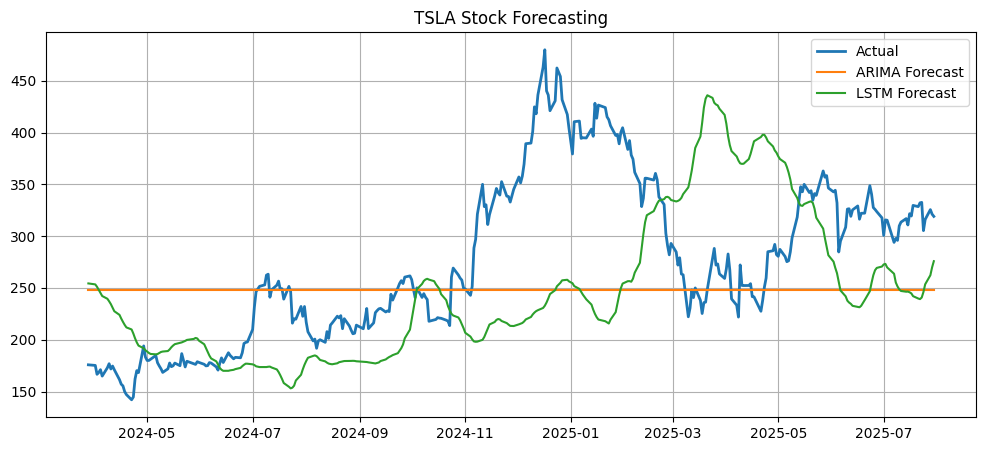

In [16]:
# Trim LSTM prediction to match the actual data length
pred_trimmed = pred_lstm.flatten()[:len(actual)]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label='Actual', linewidth=2)
plt.plot(actual.index, forecast_arima.values[:len(actual)], label='ARIMA Forecast')
plt.plot(actual.index, pred_trimmed, label='LSTM Forecast')  # trimmed LSTM
plt.title("TSLA Stock Forecasting")
plt.legend()
plt.grid()
plt.show()


# Cell 15: Discussion
# (Add markdown in the notebook)
# """
# ## Model Comparison Discussion
# - ARIMA is interpretable, performs well short-term.
# - LSTM captures complex patterns, better long-term adaptability.
# - In this case, [ModelName] performed better based on [metric].
# """
